In [1]:
import t3f
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Riemannian optimization

Riemannian optimization is a framework for solving optimization problems with a constraint that the solution belongs to a manifold. 

Let us consider the following problem. Given some TT tensor $A$ with large tt-ranks we would like to find a tensor $X$ (with small prescribed tt-ranks $r$) which is closest to $A$ (in the sense of Frobenius norm). Mathematically it can be written as follows:
\begin{equation*}
\begin{aligned}
& \underset{X}{\text{minimize}} 
& & \frac{1}{2}\|X - A\|_F^2 \\
& \text{subject to} 
& & \text{tt_rank}(X) = r
\end{aligned}
\end{equation*}

It is known that the set of TT tensors with elementwise fixed TT ranks forms a manifold. Thus we can solve this problem using the so called Riemannian gradient descent. Given some functional $F$ on a manifold $\mathcal{M}$  it is defined as
$$\hat{x}_{k+1} = x_{k} - \alpha P_{T_{x_k}\mathcal{M}} \nabla F(x_k),$$
$$x_{k+1} = \mathcal{R}(\hat{x}_{k+1})$$
with $P_{T_{x_k}\mathcal{M}}$ being the projection onto the tangent space of $\mathcal{M}$ at the point $x_k$ and $\mathcal{R}$ being a retraction - an operation which projects points to the manifold, and $\alpha$ is the learning rate.

We can implement this in `t3f` using the `t3f.riemannian` module. As a retraction it is convenient to use the rounding method (`t3f.round`).

In [2]:
sess = tf.InteractiveSession()

In [3]:
# Initialize A randomly, with large tt-ranks
shape = 10 * [2]
init_A = t3f.random_tensor(shape, tt_rank=16)
A = t3f.get_variable('A', initializer=init_A, trainable=False)

In [4]:
# Create an X variable and compute the gradient of the functional. Note that it is simply X - A.

init_X = t3f.random_tensor(shape, tt_rank=2)
X = t3f.get_variable('X', initializer=init_X)

gradF = X - A

In [5]:
# Let us compute the projection of the gradient onto the tangent space at X

In [6]:
riemannian_grad = t3f.riemannian.project(gradF, X)

In [7]:
# Compute the update by subtracting the Riemannian gradient
# and retracting back to the manifold
alpha = 1.0

train_step = t3f.assign(X, t3f.round(X - alpha * riemannian_grad, max_tt_rank=2))

In [8]:
# let us also compute the value of the functional
# to see if it is decreasing
F = 0.5 * t3f.frobenius_norm_squared(X - A)

In [9]:
sess.run(tf.global_variables_initializer())

In [10]:
log = []
for i in range(100):
    F_v, _ = sess.run([F, train_step.op])
    if i % 10 == 0:
        print (F_v)
    log.append(F_v)

1114.92
728.428
680.88
679.751
679.742
679.742
679.742
679.742
679.742
679.742


It is intructive to compare the obtained result with the quasioptimum delivered by the TT-round procedure. 

In [11]:
quasi_sol = t3f.round(A, max_tt_rank=2)

val = sess.run(0.5 * t3f.frobenius_norm_squared(quasi_sol - A))
print (val)

716.919


We see that the value is slightly bigger than the exact minimum, but TT-round is faster and cheaper to compute, so it is often used in practice.

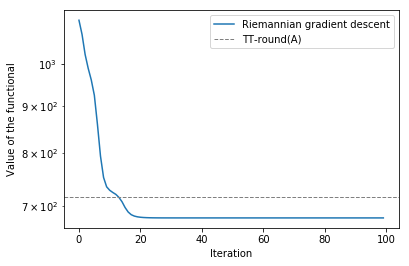

In [12]:
plt.semilogy(log, label='Riemannian gradient descent')
plt.axhline(y=val, lw=1, ls='--', color='gray', label='TT-round(A)')
plt.xlabel('Iteration')
plt.ylabel('Value of the functional')
plt.legend()